In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from pmdarima import auto_arima
import warnings

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("WARNING: 'prophet' library not found. The Prophet section will be skipped.")
    print("Install it via: pip install prophet")

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Install it via: pip install prophet


In [3]:
# --- 1. DATA LOADING & CLEANING ---

df = pd.read_csv('data/clean_data.csv')

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

# Set time as index for easier plotting and manipulation
df.set_index('time', inplace=True)

# Filter for data where we actually have PM2.5
df_model = df.dropna(subset=['aqi_pm25']).copy()

print(f"Original Data Range: {df.index.min()} to {df.index.max()}")
print(f"Modeling Data Range: {df_model.index.min()} to {df_model.index.max()}")
print(f"Total samples for modeling: {len(df_model)}")

Original Data Range: 2022-08-05 07:00:00 to 2025-11-19 23:00:00
Modeling Data Range: 2022-08-05 07:00:00 to 2025-11-19 23:00:00
Total samples for modeling: 28865


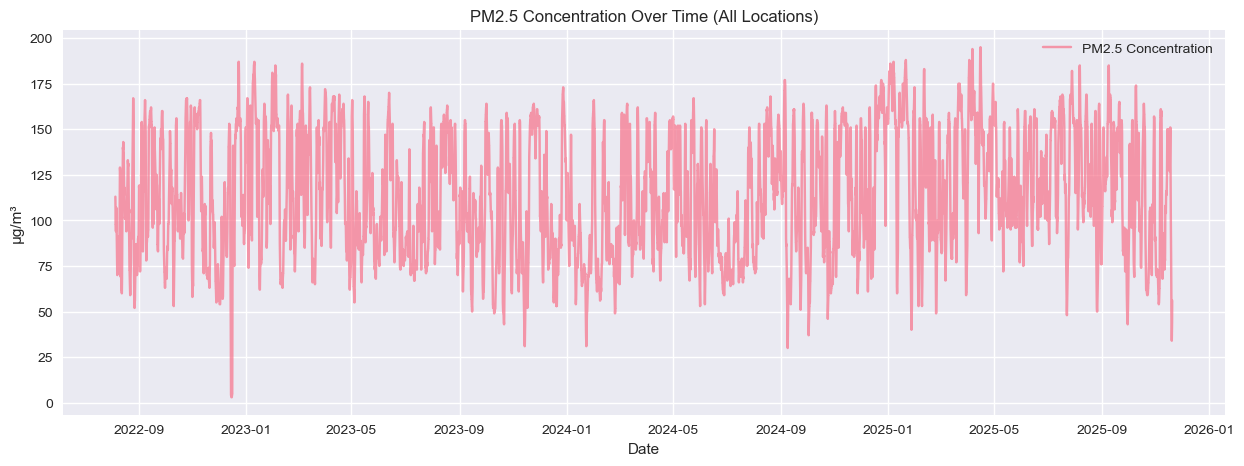

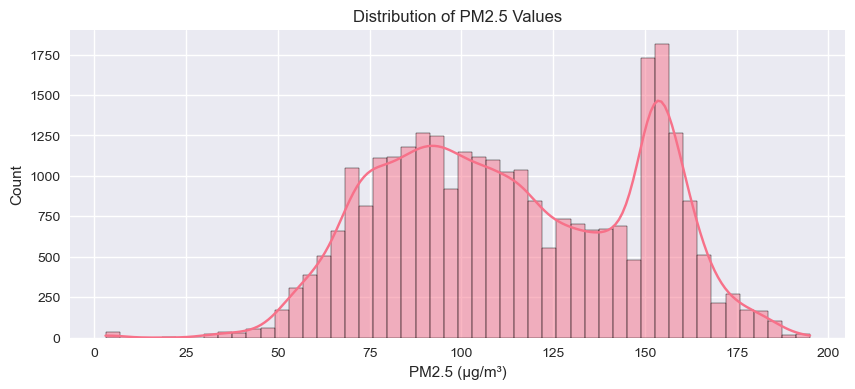

In [5]:
# --- 2. BASIC EDA ---

# Plot the Target Variable (PM2.5)
plt.figure(figsize=(15, 5))
plt.plot(df_model.index, df_model['aqi_pm25'], label='PM2.5 Concentration', alpha=0.7)
plt.title('PM2.5 Concentration Over Time (All Locations)')
plt.ylabel('µg/m³')
plt.xlabel('Date')
plt.legend()
plt.show()

# Check Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df_model['aqi_pm25'], kde=True, bins=50)
plt.title('Distribution of PM2.5 Values')
plt.xlabel('PM2.5 (µg/m³)')
plt.show()

In [6]:
print(df_model.columns)

Index(['temperature_2m', 'relative_humidity_2m', 'rain', 'wind_direction_10m',
       'wind_speed_10m', 'aqi_pm25', 'hour', 'month', 'day_of_week',
       'is_weekend', 'is_raining'],
      dtype='object')


In [8]:
# --- 3. FEATURE ENGINEERING ---
def get_aqi_category(aqi):
    """Returns the textual category for a given AQI value (US Standard)."""
    if aqi is None or np.isnan(aqi):
        return None
    
    val = int(aqi)
    if val <= 50: return "Good"
    if val <= 100: return "Moderate"
    if val <= 150: return "Unhealthy for Sensitive Groups"
    if val <= 200: return "Unhealthy"
    if val <= 300: return "Very Unhealthy"
    return "Hazardous"
    
def engineer_features_multistep(data):
    """
    Prepares data for multi-step forecasting (t+1 to t+24).
    Row 't' will contain:
      - X: Weather(t), Time(t), PM25(t), PM25(t-1)...
      - y: PM25(t+1), PM25(t+2)... PM25(t+24)
    """
    df_eng = data.copy()
    
    # Location encoding if existed
    if 'lat' in df_eng.columns and 'lon' in df_eng.columns:
        df_eng['loc_id'] = df_eng['lat'].astype(str) + '_' + df_eng['lon'].astype(str)
        loc_dummies = pd.get_dummies(df_eng['loc_id'], prefix='loc')
        loc_dummies = loc_dummies.astype(int)
        df_eng = pd.concat([df_eng, loc_dummies], axis=1)
        loc_features = loc_dummies.columns.tolist()
    else:
        loc_features = []

    # encode month and day_of_week as integers
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    dow_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
        'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }

    df_eng['month'] = df_eng['month'].map(month_map).astype(int)
    df_eng['day_of_week'] = df_eng['day_of_week'].map(dow_map).astype(int)

    # Cyclic time features
    df_eng['hour_sin'] = np.sin(2 * np.pi * df_eng.index.hour / 24)
    df_eng['hour_cos'] = np.cos(2 * np.pi * df_eng.index.hour / 24)
    df_eng['month_sin'] = np.sin(2 * np.pi * df_eng.index.month / 12)
    df_eng['month_cos'] = np.cos(2 * np.pi * df_eng.index.month / 12)
    
    # Wind direction (Handle multiple naming conventions)
    wind_col = None
    for col_name in ['wind_dir', 'wind_direction_10m']:
        if col_name in df_eng.columns:
            wind_col = col_name
            break
            
    if wind_col and 'wind_sin' not in df_eng.columns:
        df_eng['wind_sin'] = np.sin(np.deg2rad(df_eng[wind_col]))
        df_eng['wind_cos'] = np.cos(np.deg2rad(df_eng[wind_col]))

    # Past target value as features
    target_var = 'aqi_pm25'
    lags = [1, 2, 3, 6, 12, 24]
    for lag in lags:
        df_eng[f'{target_var}_lag{lag}'] = df_eng[target_var].shift(lag)
        
    # Rolling Stats
    df_eng['aqi_pm25_roll_mean_24h'] = df_eng[target_var].shift(1).rolling(window=24).mean()
    
    # TARGETS
    H = 24
    target_cols = []
    for h in range(1, H+1):
        col_name = f'{target_var}_t+{h}'
        df_eng[col_name] = df_eng[target_var].shift(-h)
        target_cols.append(col_name)

    # Cleanup
    df_eng.dropna(inplace=True)
    
    # FEATURE SELECTION
    possible_weather = ['aqi_pm25',
        # Dataset 1 styles
        'temp', 'pres', 'wind_spd', 'wind_gust_spd', 'precip', 'humidity', 'no2', 'so2', 'co',
        # Dataset 2 styles
        'temperature_2m', 'relative_humidity_2m', 'is_raining', 'wind_speed_10m'
    ]
    possible_weather += ['wind_sin', 'wind_cos', 'pm25_roll_mean_24h']
    weather_feats = [c for c in possible_weather if c in df_eng.columns]

    # Base Time features for trees
    time_orig_feats = ['hour', 'month', 'day_of_week']
    
    # Derived Time features
    time_eng_feats = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    # Past PM2.5 features
    lag_feats = [f'{target_var}_lag{l}' for l in lags]
    
    # Full Input List
    X_cols = weather_feats + lag_feats + loc_features
    
    return df_eng, X_cols, target_cols, time_orig_feats, time_eng_feats

df_processed, X_cols, target_cols, time_orig_cols, time_eng_cols = engineer_features_multistep(df_model)
X = df_processed[X_cols + time_eng_cols]
y = df_processed[target_cols]
print(f"Data shape before engineering: {df_model.shape}")
print(f"Data shape after engineering: {df_processed.shape}")


Data shape before engineering: (28865, 11)
Data shape after engineering: (28817, 48)


In [9]:
print(X.columns)
print(y.columns)

Index(['aqi_pm25', 'temperature_2m', 'relative_humidity_2m', 'is_raining',
       'wind_speed_10m', 'wind_sin', 'wind_cos', 'aqi_pm25_lag1',
       'aqi_pm25_lag2', 'aqi_pm25_lag3', 'aqi_pm25_lag6', 'aqi_pm25_lag12',
       'aqi_pm25_lag24', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'],
      dtype='object')
Index(['aqi_pm25_t+1', 'aqi_pm25_t+2', 'aqi_pm25_t+3', 'aqi_pm25_t+4',
       'aqi_pm25_t+5', 'aqi_pm25_t+6', 'aqi_pm25_t+7', 'aqi_pm25_t+8',
       'aqi_pm25_t+9', 'aqi_pm25_t+10', 'aqi_pm25_t+11', 'aqi_pm25_t+12',
       'aqi_pm25_t+13', 'aqi_pm25_t+14', 'aqi_pm25_t+15', 'aqi_pm25_t+16',
       'aqi_pm25_t+17', 'aqi_pm25_t+18', 'aqi_pm25_t+19', 'aqi_pm25_t+20',
       'aqi_pm25_t+21', 'aqi_pm25_t+22', 'aqi_pm25_t+23', 'aqi_pm25_t+24'],
      dtype='object')


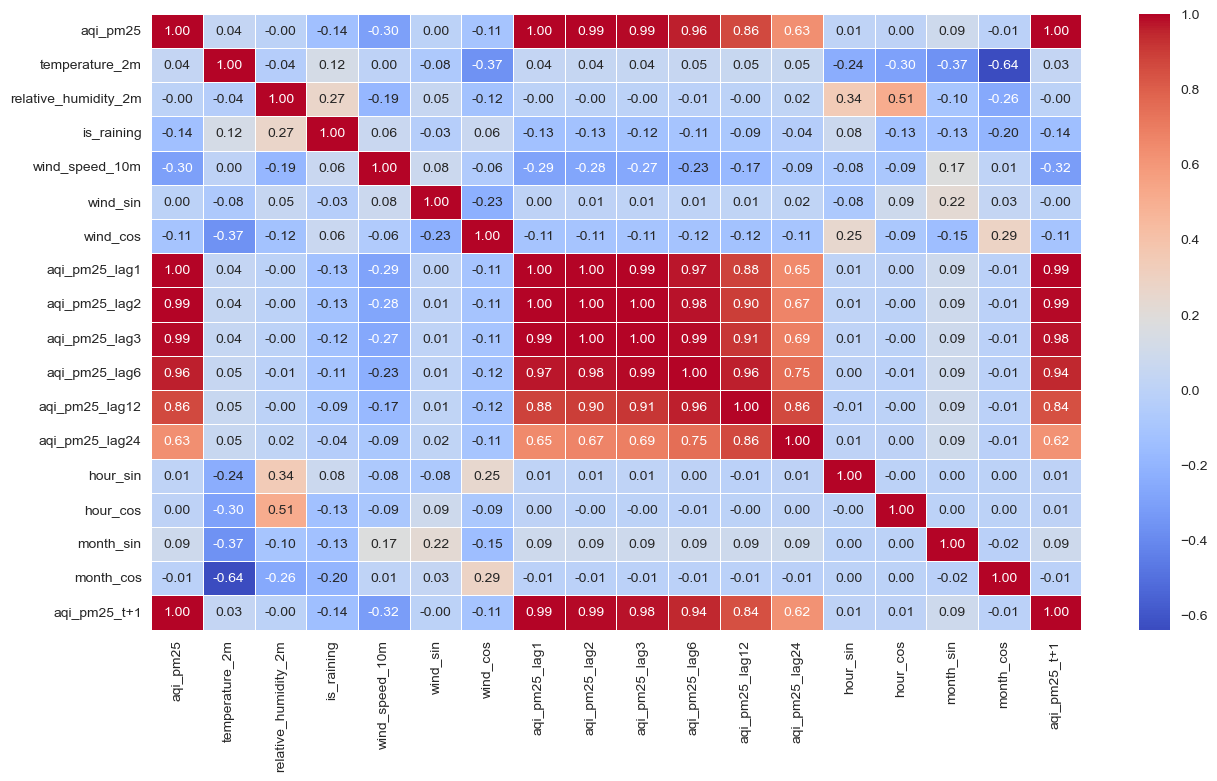

In [11]:
X_with_target = X.copy()

target = 'aqi_pm25_t+1'
X_with_target[target] = y[target]

corr_matrix = X_with_target.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

In [12]:
# Feature selection based on correlation threshold
threshold = 0.1

corr_matrix.drop(time_eng_cols, inplace=True)

corr_with_target = corr_matrix.get(target, pd.Series()).abs()
selected_features = corr_with_target[corr_with_target > threshold].sort_values(ascending=False).index.tolist()
selected_features = [f for f in selected_features if f != target]

# Fallback to manual list if nothing selected
if not selected_features:
    selected_features = X_cols

features_str = '\n'.join(selected_features)
print(f"Selected {len(selected_features)} features with |corr| > {threshold}:\n{features_str}")

Selected 10 features with |corr| > 0.1:
aqi_pm25
aqi_pm25_lag1
aqi_pm25_lag2
aqi_pm25_lag3
aqi_pm25_lag6
aqi_pm25_lag12
aqi_pm25_lag24
wind_speed_10m
is_raining
wind_cos


In [13]:
# Chronological Split (80/20)
split_idx = int(len(df_processed) * 0.8)
train_df = df_processed.iloc[:split_idx]
test_df = df_processed.iloc[split_idx:]

X_train = train_df[selected_features + time_eng_cols]
y_train = train_df[target_cols]
X_test = test_df[selected_features + time_eng_cols]
y_test = test_df[target_cols]

X_train_tree = train_df[selected_features + time_orig_cols]
X_test_tree = test_df[selected_features + time_orig_cols]

print(f"Train Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")
print(f"Target Shape: {y_train.shape}")
print(f"Test Start Date: {test_df.index.min()}")
print(f"\nInput features: {X_test.columns}")

Train Set Shape: (23053, 14)
Test Set Shape: (5764, 14)
Target Shape: (23053, 24)
Test Start Date: 2025-03-23 20:00:00

Input features: Index(['aqi_pm25', 'aqi_pm25_lag1', 'aqi_pm25_lag2', 'aqi_pm25_lag3',
       'aqi_pm25_lag6', 'aqi_pm25_lag12', 'aqi_pm25_lag24', 'wind_speed_10m',
       'is_raining', 'wind_cos', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos'],
      dtype='object')


In [14]:
def evaluate_multi_step(name, y_true, y_pred):
    """
    Evaluates multi-step forecasts and prints a formatted table.
    Dynamically handles inputs with fewer than 24 columns (e.g. only t+1).
    
    y_true: numpy array/DataFrame of shape (n_samples, n_horizons)
    y_pred: numpy array/DataFrame of shape (n_samples, n_horizons)
    """
    
    # 1. Convert to Numpy
    if hasattr(y_true, 'values'):
        y_true = y_true.values
    if hasattr(y_pred, 'values'):
        y_pred = y_pred.values
        
    # 2. Handle 1D inputs (Shape N,) -> Reshape to (N, 1)
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    # 3. Determine available columns based on Prediction input
    # We assume y_true corresponds to y_pred (or has at least as many cols)
    num_cols = y_pred.shape[1]
        
    # Define the horizons we want to report
    horizons = [1, 2, 3, 6, 12, 24]
    
    # Header Formatting
    header = f"{'Metric':<10} |"
    for h in horizons:
        header += f" {'t+'+str(h):<8} |"
    header += f" {'Overall':<8}"
    
    print(f"\n--- {name} Performance ---")
    print("-" * len(header))
    print(header)
    print("-" * len(header))
    
    # 4. Calculate Per-Step Metrics
    step_results = {}
    
    for h in horizons:
        col_idx = h - 1
        
        # Only calculate if we have data for this horizon
        if col_idx < num_cols:
            # Safely slice both arrays
            # (Assumes y_true has at least as many columns as y_pred)
            if col_idx < y_true.shape[1]:
                true_col = y_true[:, col_idx]
                pred_col = y_pred[:, col_idx]
                
                rmse = np.sqrt(mean_squared_error(true_col, pred_col))
                mae = mean_absolute_error(true_col, pred_col)
                r2 = r2_score(true_col, pred_col)
                
                step_results[h] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
            else:
                 # y_pred has col but y_true doesn't (mismatch)
                 step_results[h] = None
        else:
            # Horizon beyond what was predicted
            step_results[h] = None

    # 5. Calculate Overall Metrics (Average across valid columns)
    # We limit y_true to the same number of columns as y_pred for fairness
    if num_cols > 0:
        y_true_sliced = y_true[:, :num_cols]
        y_pred_sliced = y_pred[:, :num_cols]
        
        overall_rmse = np.sqrt(mean_squared_error(y_true_sliced, y_pred_sliced))
        overall_mae = mean_absolute_error(y_true_sliced, y_pred_sliced)
        overall_r2 = r2_score(y_true_sliced, y_pred_sliced)
    else:
        overall_rmse = overall_mae = overall_r2 = None

    # 6. Print Rows
    for metric_name in ['RMSE', 'MAE', 'R2']:
        row_str = f"{metric_name:<10} |"
        
        for h in horizons:
            val = step_results.get(h)
            
            if val is not None:
                # Format actual numbers
                fmt = "<8.3f" if metric_name == 'R2' else "<8.2f"
                row_str += f" {val[metric_name]:{fmt}} |"
            else:
                # Format empty cell
                row_str += f" {'-':<8} |"
        
        # Add Overall column
        if overall_rmse is not None:
            val = overall_r2 if metric_name == 'R2' else (overall_rmse if metric_name == 'RMSE' else overall_mae)
            fmt = "<8.3f" if metric_name == 'R2' else "<8.2f"
            row_str += f" {val:{fmt}}"
        else:
            row_str += f" {'-':<8}"
            
        print(row_str)
    print("-" * len(header))

In [36]:
def get_aqi_category_vectorized(aqi_values):
    """
    Vectorized conversion of AQI values to category indices.
    Categories: 0=Good, 1=Moderate, 2=Unhealthy for Sensitive Groups,
                3=Unhealthy, 4=Very Unhealthy, 5=Hazardous
    """
    aqi = np.asarray(aqi_values)
    categories = np.zeros_like(aqi, dtype=int)
    categories[aqi > 50] = 1   # Moderate
    categories[aqi > 100] = 2  # Unhealthy for Sensitive Groups
    categories[aqi > 150] = 3  # Unhealthy
    categories[aqi > 200] = 4  # Very Unhealthy
    categories[aqi > 300] = 5  # Hazardous
    return categories

def evaluate_category_accuracy(name, y_true, y_pred):
    """
    Evaluates multi-step forecasts based on AQI category accuracy.
    Prints a formatted table showing category accuracy at different horizons.
    
    y_true: numpy array/DataFrame of shape (n_samples, n_horizons)
    y_pred: numpy array/DataFrame of shape (n_samples, n_horizons)
    """
    # Convert to Numpy
    if hasattr(y_true, 'values'):
        y_true = y_true.values
    if hasattr(y_pred, 'values'):
        y_pred = y_pred.values
        
    # Handle 1D inputs
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    num_cols = y_pred.shape[1]
    horizons = [1, 2, 3, 6, 12, 24]
    
    # Convert to categories
    true_cats = get_aqi_category_vectorized(y_true)
    pred_cats = get_aqi_category_vectorized(y_pred)
    
    # Header
    header = f"{'Metric':<12} |"
    for h in horizons:
        header += f" {'t+'+str(h):<8} |"
    header += f" {'Overall':<8}"
    
    print(f"\n--- {name} Category Accuracy ---")
    print("-" * len(header))
    print(header)
    print("-" * len(header))
    
    # Calculate per-step accuracy
    step_results = {}
    for h in horizons:
        col_idx = h - 1
        if col_idx < num_cols and col_idx < y_true.shape[1]:
            correct = (true_cats[:, col_idx] == pred_cats[:, col_idx]).sum()
            total = len(true_cats[:, col_idx])
            step_results[h] = correct / total * 100
        else:
            step_results[h] = None
    
    # Overall accuracy
    if num_cols > 0:
        true_cats_sliced = true_cats[:, :num_cols]
        pred_cats_sliced = pred_cats[:, :num_cols]
        overall_acc = (true_cats_sliced == pred_cats_sliced).sum() / true_cats_sliced.size * 100
    else:
        overall_acc = None
    
    # Print accuracy row
    row_str = f"{'Accuracy %':<12} |"
    for h in horizons:
        val = step_results.get(h)
        if val is not None:
            row_str += f" {val:<8.2f} |"
        else:
            row_str += f" {'-':<8} |"
    
    if overall_acc is not None:
        row_str += f" {overall_acc:<8.2f}"
    else:
        row_str += f" {'-':<8}"
    
    print(row_str)
    print("-" * len(header))
    
    return step_results, overall_acc

### Baseline: Persistence

In [16]:
# 0. Baseline: Persistence Model (Naive Forecast)
# Prediction for t+n is simply the value at t
y_pred_persist = np.tile(X_test['aqi_pm25_lag1'].values.reshape(-1, 1), (1, 24))
evaluate_multi_step('Persistence (Baseline)', y_test, y_pred_persist)


--- Persistence (Baseline) Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 3.72     | 5.45     | 7.12     | 11.65    | 18.99    | 29.44    | 20.02   
MAE        | 2.46     | 3.64     | 4.79     | 8.03     | 13.75    | 22.58    | 13.61   
R2         | 0.986    | 0.970    | 0.949    | 0.863    | 0.639    | 0.142    | 0.601   
---------------------------------------------------------------------------------------


### Linear Regression

In [17]:
# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
evaluate_multi_step('Linear Regression', y_test, y_pred_lr)


--- Linear Regression Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 0.95     | 1.88     | 2.98     | 6.68     | 13.51    | 23.48    | 14.89   
MAE        | 0.68     | 1.32     | 2.08     | 4.69     | 9.90     | 18.62    | 9.96    
R2         | 0.999    | 0.996    | 0.991    | 0.955    | 0.817    | 0.454    | 0.779   
---------------------------------------------------------------------------------------


### XGBoost

In [19]:
# 2.1. XGBoost
print("\n--- Starting Hyperparameter Tuning ---")
print("Go grab a drink as this may take a few minutes...")

# Define the parameter grid
param_dist = {
    'n_estimators': [500, 1000],            # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # Step size
    'max_depth': [3, 5, 7, 9],              # Tree depth (prevent overfitting)
    'subsample': [0.7, 0.8, 0.9],           # % of data used per tree
    'colsample_bytree': [0.7, 0.8, 0.9],    # % of features used per tree
    'min_child_weight': [1, 3, 5]           # helps prevent over-fitting on noise
}

# Base model
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# TimeSeriesSplit ensures we don't shuffle data during Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# Randomized Search (faster than Grid Search)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_tree, y_train['aqi_pm25_t+1'])

best_params = random_search.best_params_
print(f"\nBest Parameters Found: {best_params}")

# Train with best params
best_xgb = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

best_xgb.fit(
    X_train_tree, y_train,
    eval_set=[(X_test_tree, y_test)],
    verbose=False
)


--- Starting Hyperparameter Tuning ---
Go grab a drink as this may take a few minutes...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
y_pred_xgb = best_xgb.predict(X_test_tree)
evaluate_multi_step('XGBoost', y_test, y_pred_xgb)


--- XGBoost Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 1.28     | 2.32     | 3.44     | 7.06     | 13.73    | 24.43    | 15.42   
MAE        | 0.90     | 1.64     | 2.43     | 5.05     | 10.17    | 19.62    | 10.48   
R2         | 0.998    | 0.995    | 0.988    | 0.950    | 0.811    | 0.409    | 0.763   
---------------------------------------------------------------------------------------


In [22]:
# 2.1.1. XGBoost with engineered time features
print("\n--- Starting Hyperparameter Tuning ---")
print("Go grab a drink as this may take a few minutes...")

# Define the parameter grid
param_dist = {
    'n_estimators': [500, 1000],            # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # Step size
    'max_depth': [3, 5, 7, 9],              # Tree depth (prevent overfitting)
    'subsample': [0.7, 0.8, 0.9],           # % of data used per tree
    'colsample_bytree': [0.7, 0.8, 0.9],    # % of features used per tree
    'min_child_weight': [1, 3, 5]           # helps prevent over-fitting on noise
}

# Base model
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# TimeSeriesSplit ensures we don't shuffle data during Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# Randomized Search (faster than Grid Search)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train['aqi_pm25_t+1'])

best_params = random_search.best_params_
print(f"\nBest Parameters Found: {best_params}")

# Train with best params
best_xgb = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


--- Starting Hyperparameter Tuning ---
Go grab a drink as this may take a few minutes...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
y_pred_xgb = best_xgb.predict(X_test)
evaluate_multi_step('XGBoost', y_test, y_pred_xgb)


--- XGBoost Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 1.33     | 2.55     | 3.62     | 7.31     | 14.03    | 24.83    | 15.61   
MAE        | 0.93     | 1.81     | 2.57     | 5.28     | 10.54    | 19.97    | 10.68   
R2         | 0.998    | 0.993    | 0.987    | 0.946    | 0.803    | 0.389    | 0.757   
---------------------------------------------------------------------------------------


### Random Forest

In [24]:
# 2.2. Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_tree, y_train)

RandomForestRegressor(max_depth=25, min_samples_leaf=2, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [25]:
y_pred_rf = rf.predict(X_test_tree)
evaluate_multi_step('Random Forest', y_test, y_pred_rf)


--- Random Forest Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 1.86     | 2.84     | 3.96     | 7.61     | 14.46    | 24.93    | 15.98   
MAE        | 1.32     | 2.05     | 2.86     | 5.52     | 10.79    | 19.83    | 10.93   
R2         | 0.996    | 0.992    | 0.984    | 0.942    | 0.790    | 0.385    | 0.746   
---------------------------------------------------------------------------------------


### AQI Category Accuracy Evaluation

Compare models based on how often they predict the correct AQI category:
- **Good** (0-50), **Moderate** (51-100), **Unhealthy for Sensitive Groups** (101-150)
- **Unhealthy** (151-200), **Very Unhealthy** (201-300), **Hazardous** (300+)

In [37]:
# Evaluate all models on AQI Category Accuracy
print("=" * 60)
print("AQI CATEGORY ACCURACY COMPARISON")
print("=" * 60)

# Persistence Baseline
y_pred_persist = np.tile(X_test['aqi_pm25_lag1'].values.reshape(-1, 1), (1, 24))
evaluate_category_accuracy('Persistence (Baseline)', y_test, y_pred_persist)

# Linear Regression
y_pred_lr = lr_model.predict(X_test)
evaluate_category_accuracy('Linear Regression', y_test, y_pred_lr)

# XGBoost
y_pred_xgb = best_xgb.predict(X_test)
evaluate_category_accuracy('XGBoost', y_test, y_pred_xgb)

# Random Forest
y_pred_rf = rf.predict(X_test_tree)
evaluate_category_accuracy('Random Forest', y_test, y_pred_rf)

AQI CATEGORY ACCURACY COMPARISON

--- Persistence (Baseline) Category Accuracy ---
-----------------------------------------------------------------------------------------
Metric       | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
-----------------------------------------------------------------------------------------
Accuracy %   | 94.76    | 92.26    | 89.73    | 82.89    | 71.84    | 57.84    | 72.94   
-----------------------------------------------------------------------------------------

--- Linear Regression Category Accuracy ---
-----------------------------------------------------------------------------------------
Metric       | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
-----------------------------------------------------------------------------------------
Accuracy %   | 97.76    | 96.01    | 94.27    | 88.78    | 77.15    | 56.85    | 76.57   
--------------------------------------------------------------

({1: 96.56488549618321,
  2: 94.98612074947953,
  3: 93.19916724496878,
  6: 86.97085357390702,
  12: 75.10409437890354,
  24: 54.80569049271339},
 74.95951885264861)

aqi_pm25          0.749159
wind_speed_10m    0.047815
aqi_pm25_lag6     0.035047
aqi_pm25_lag24    0.030821
aqi_pm25_lag12    0.027066
month             0.025907
wind_cos          0.021123
hour              0.017470
day_of_week       0.016850
aqi_pm25_lag3     0.011859
aqi_pm25_lag2     0.006415
is_raining        0.006407
aqi_pm25_lag1     0.004060
dtype: float64


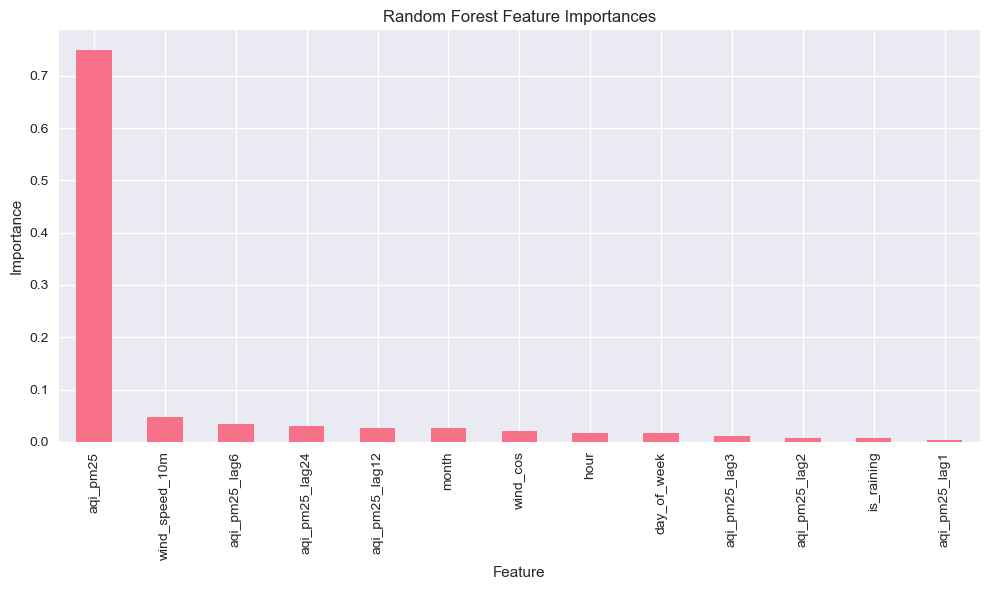

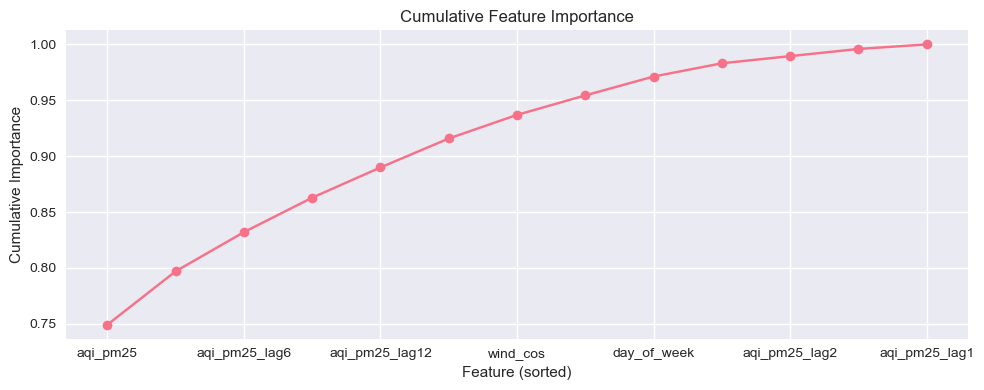

In [26]:
# get feature importances from the trained model
importances = rf.feature_importances_
fi = pd.Series(importances, index=X_train_tree.columns).sort_values(ascending=False)

# display
print(fi)

# bar plot of importances
plt.figure(figsize=(10,6))
fi.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# cumulative importance plot
plt.figure(figsize=(10,4))
fi.cumsum().plot(marker='o')
plt.title("Cumulative Feature Importance")
plt.ylabel("Cumulative Importance")
plt.xlabel("Feature (sorted)")
plt.grid(True)
plt.tight_layout()
plt.show()

### SARIMAX

In [27]:
# D. SARIMAX (Level 2.1)
df_ts = df_processed.asfreq('h')
df_ts = df_ts.interpolate(method='time')

print(df_ts.shape)
print(df_ts.columns)

(28817, 48)
Index(['temperature_2m', 'relative_humidity_2m', 'rain', 'wind_direction_10m',
       'wind_speed_10m', 'aqi_pm25', 'hour', 'month', 'day_of_week',
       'is_weekend', 'is_raining', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'wind_sin', 'wind_cos', 'aqi_pm25_lag1', 'aqi_pm25_lag2',
       'aqi_pm25_lag3', 'aqi_pm25_lag6', 'aqi_pm25_lag12', 'aqi_pm25_lag24',
       'aqi_pm25_roll_mean_24h', 'aqi_pm25_t+1', 'aqi_pm25_t+2',
       'aqi_pm25_t+3', 'aqi_pm25_t+4', 'aqi_pm25_t+5', 'aqi_pm25_t+6',
       'aqi_pm25_t+7', 'aqi_pm25_t+8', 'aqi_pm25_t+9', 'aqi_pm25_t+10',
       'aqi_pm25_t+11', 'aqi_pm25_t+12', 'aqi_pm25_t+13', 'aqi_pm25_t+14',
       'aqi_pm25_t+15', 'aqi_pm25_t+16', 'aqi_pm25_t+17', 'aqi_pm25_t+18',
       'aqi_pm25_t+19', 'aqi_pm25_t+20', 'aqi_pm25_t+21', 'aqi_pm25_t+22',
       'aqi_pm25_t+23', 'aqi_pm25_t+24'],
      dtype='object')


In [29]:
# Perform ADF test
df_pm25 = df_processed[['aqi_pm25']].copy()
adf_result = adfuller(df_pm25)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -13.507674887100901
p-value: 2.8940225466153344e-25
Critical Values: {'1%': -3.430577347689359, '5%': -2.861640481375097, '10%': -2.5668234831971772}


Generating Diagnostics Plots...


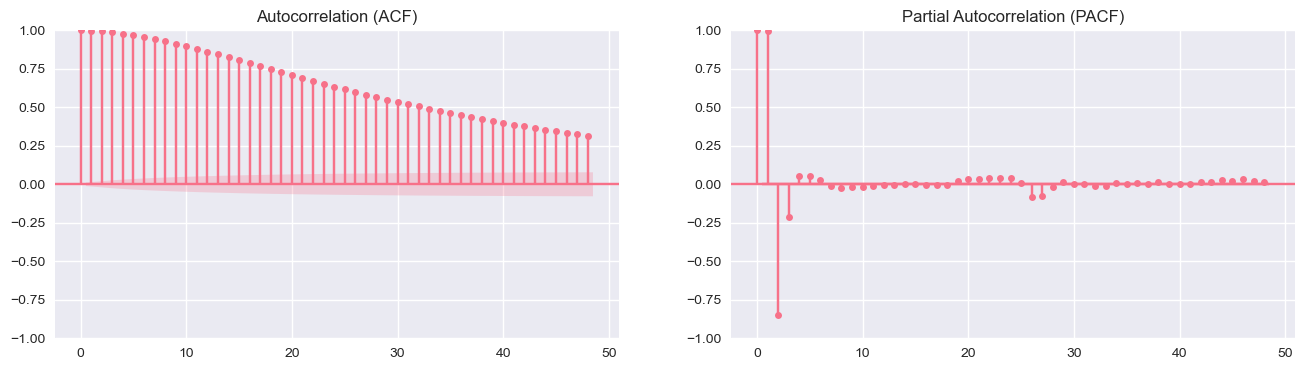

In [31]:
# We analyze the STATIONARITY and Autocorrelation
print("Generating Diagnostics Plots...")

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# Original Series
# Note: PM2.5 is usually stationary-ish, but seasonality might need differencing
plot_acf(df_ts['aqi_pm25'].dropna(), lags=48, ax=axes[0], title='Autocorrelation (ACF)')
plot_pacf(df_ts['aqi_pm25'].dropna(), lags=48, ax=axes[1], title='Partial Autocorrelation (PACF)')
plt.show()

# Interpretation:
# ACF decaying slowly -> Needs differencing or has strong trend/seasonality
# PACF cuts off after lag k -> Suggests AR(k) model

In [33]:
train_ts = df_ts.iloc[:int(len(df_ts)*0.8)]
test_ts = df_ts.iloc[int(len(df_ts)*0.8):]
print(f'train_ts shape: {train_ts.shape}, test_ts shape: {test_ts.shape}')

exog_cols = selected_features + time_eng_cols
exog_cols.remove('aqi_pm25')
print(exog_cols)

train_ts shape: (23053, 48), test_ts shape: (5764, 48)
['aqi_pm25_lag1', 'aqi_pm25_lag2', 'aqi_pm25_lag3', 'aqi_pm25_lag6', 'aqi_pm25_lag12', 'aqi_pm25_lag24', 'wind_speed_10m', 'is_raining', 'wind_cos', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [34]:
print("Running Auto-ARIMA search (Stepwise)...")

arimax_model = auto_arima(
    train_ts['pm25'],
    exogenous=train_ts[exog_cols],
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    d=None,           
    seasonal=False,   # <--- MEMORY FIX
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

print(arimax_model.summary())
print(f"Best Order: {arimax_model.order}")

Running Auto-ARIMA search (Stepwise)...


NameError: name 'auto_arima' is not defined

In [25]:
pred_arima, conf_int = arimax_model.predict(
    n_periods=len(test_ts), 
    exogenous=test_ts[exog_cols],
    return_conf_int=True
)

evaluate_multi_step('ARIMAX', test_ts['pm25_t+1'], pred_arima)


--- ARIMAX Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 45.69    | -        | -        | -        | -        | -        | 45.69   
MAE        | 41.22    | -        | -        | -        | -        | -        | 41.22   
R2         | -1.350   | -        | -        | -        | -        | -        | -1.350  
---------------------------------------------------------------------------------------


In [26]:
# # E. Facebook Prophet (Level 2.2)

# if PROPHET_AVAILABLE:
#     # Prepare DF
#     df_prophet = df_ts.reset_index()[['time', 'pm25'] + exog_cols].copy()
#     df_prophet.rename(columns={'time': 'ds', 'pm25': 'y'}, inplace=True)
    
#     # Split
#     split_p = int(len(df_prophet)*0.8)
#     train_prophet = df_prophet.iloc[:split_p]
#     test_prophet = df_prophet.iloc[split_p:]
    
#     # Initialize Model
#     # We turn OFF daily_seasonality first, then add it manually with fourier_order
#     # to have more control, or stick to default. Default is usually fine if TZ is fixed.
#     m = Prophet(daily_seasonality=True, weekly_seasonality=True)
    
#     # Add Regressors
#     for col in exog_cols:
#         # 'hour_sin' and 'hour_cos' might be redundant with daily_seasonality=True,
#         # but kept here for consistency with other models.
#         m.add_regressor(col)

#     print("Fitting Prophet...")
#     m.fit(train_prophet)
# else:
#     print("Skipped Prophet.")

In [27]:
# # Predict
# # Prophet needs a future dataframe that includes the dates AND the regressor values
# future = test_prophet.drop(columns=['y'])
# forecast = m.predict(future)

# # Extract prediction
# y_pred_prophet = forecast['yhat'].values
# y_true_prophet = test_prophet['y'].values

# results['Prophet'] = evaluate_model('Prophet', y_true_prophet, y_pred_prophet)

In [28]:
# F. LSTM (Deep Learning - Level 3)